In [293]:
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import torchvision
import torchvision.transforms as T

plt.rcParams["savefig.bbox"] = 'tight'

In [294]:
raw_folders = ['good 1', 'good 2']
raw_remove_count = [0, 0]

In [295]:
from utils import extract_file_name

def read_raw_driving_csv(folder: str):
    csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)

    with open(csv_path, 'r') as f:
        return pd.read_csv(
            csv_path,
            header=None,
            names=['center', 'left', 'right', 'steering_angle'],
            usecols=[0, 1, 2, 3],
            converters={
                'center': lambda x: extract_file_name(x),
                'left': lambda x: extract_file_name(x),
                'right': lambda x: extract_file_name(x)
            }
        )


In [296]:
from utils import all_paths_exist

def remove_non_triple_images(raw_folders):
    remove_indexes = []

    for folder in raw_folders:
        print('-- Checking {0}'.format(folder))

        df = read_raw_driving_csv(folder)
        print('DF Before: ', len(df))

        for index, row in df.iterrows():
            image_center_path = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['center'])
            image_left_path = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['left'])
            image_right_path = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['right'])

            # if an image does not exist, remove all images from the same row
            if not all_paths_exist([image_center_path, image_left_path, image_right_path]):
                for path in [image_center_path, image_left_path, image_right_path]:
                    if os.path.exists(path):
                        os.remove(path)

                remove_indexes.append(index)

        df.drop(labels=df.index[remove_indexes], inplace=True)
        print('DF After : ', len(df))

        csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)
        df.to_csv(csv_path, index=False, header=False)

In [297]:
remove_non_triple_images(raw_folders)

-- Checking good 1
DF Before:  10405
DF After :  10405
-- Checking good 2
DF Before:  20882
DF After :  20882


# Load and Visualize Dataset

In [298]:
def remove_random_rows(df, count=1000):
    print('--\nTotal : ', len(df))

    drop_indices = np.random.choice(df.index, count, replace=False)

    print('Removing : ', len(drop_indices))
    df.drop(drop_indices, inplace=True)
    print('Remaining : ', len(df))

In [299]:
full_set = pd.DataFrame()

for folder, remove_count in zip(raw_folders, raw_remove_count):
    df = read_raw_driving_csv(folder)
    df['folder'] = folder
    full_set = pd.concat([full_set, df], ignore_index=True)
    remove_random_rows(full_set, remove_count)

--
Total :  10405
Removing :  0
Remaining :  10405
--
Total :  31287
Removing :  0
Remaining :  31287


In [300]:
full_set.dtypes

center             object
left               object
right              object
steering_angle    float64
folder             object
dtype: object

In [301]:
full_set.head()

,center,left,right,steering_angle,folder
0,center_2019_04_02_19_25_35_023.jpg,left_2019_04_02_19_25_35_023.jpg,right_2019_04_02_19_25_35_023.jpg,0.00,good 1
1,center_2019_04_02_19_25_35_092.jpg,left_2019_04_02_19_25_35_092.jpg,right_2019_04_02_19_25_35_092.jpg,-0.15,good 1
2,center_2019_04_02_19_25_35_164.jpg,left_2019_04_02_19_25_35_164.jpg,right_2019_04_02_19_25_35_164.jpg,0.00,good 1
3,center_2019_04_02_19_25_35_232.jpg,left_2019_04_02_19_25_35_232.jpg,right_2019_04_02_19_25_35_232.jpg,0.00,good 1
4,center_2019_04_02_19_25_35_303.jpg,left_2019_04_02_19_25_35_303.jpg,right_2019_04_02_19_25_35_303.jpg,0.00,good 1


In [302]:
full_set.iloc[1]

center            center_2019_04_02_19_25_35_092.jpg
left                left_2019_04_02_19_25_35_092.jpg
right              right_2019_04_02_19_25_35_092.jpg
steering_angle                                 -0.15
folder                                        good 1
Name: 1, dtype: object

In [303]:
full_set.iloc[1]['folder']

'good 1'

In [304]:
full_set['steering_angle'][1]

-0.15

# Balance the Dataset

In [305]:
num_bins = 21
samples_per_bin = 1000

In [306]:
def show_steering_angles(full_set, hist, bins, samples_per_bin):
    center = (bins[:-1] + bins[1:]) * 0.5
    plt.bar(center, hist, width=0.05)
    plt.plot(
        (np.min(full_set['steering_angle']), np.max(full_set['steering_angle'])),
        (samples_per_bin, samples_per_bin)
    )

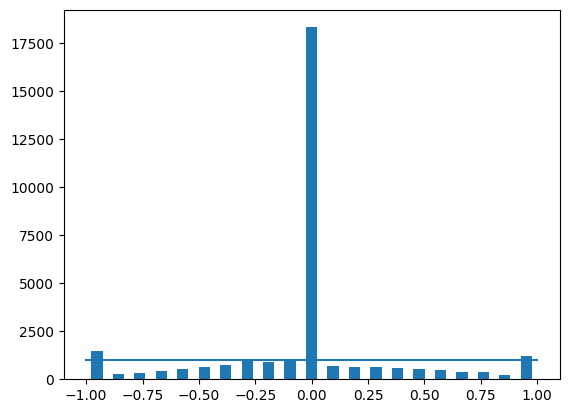

In [307]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

In [308]:
print('total data:', len(full_set))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(full_set['steering_angle'])):
    if bins[j] <= full_set['steering_angle'][i] <= bins[j + 1]:
      list_.append(i)

  random.shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
full_set.drop(full_set.index[remove_list], inplace=True)
print('remaining:', len(full_set))

total data: 31287
removed: 18018
remaining: 13269


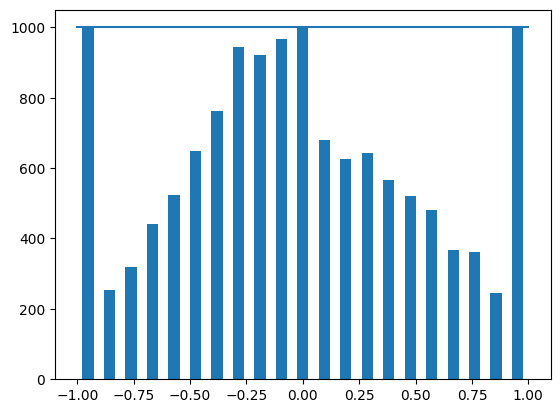

In [309]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

# Preprocess Dataset

In [310]:
import torchvision.transforms.functional as TF

def preprocess(image):
    image = TF.crop(image, top=60, left=0, height=80, width=320)
    image = TF.resize(image, [128, 128], antialias=True)
    return image

In [311]:
len(full_set)

13269

In [331]:
from torchvision.io import read_image
from PIL import Image

for index, row in full_set.iterrows():
    folder = row['folder']

    for image_name in ['center', 'left', 'right']:
        image_name = row[image_name]
        raw_path = '.\\data\\raw\\' + folder + '\\IMG\\' + image_name

        if not os.path.exists(raw_path):
            continue

        image = read_image(raw_path)
        # print('Original Shape : ', image.shape)
        image = preprocess(image)
        # print('New Shape : ', image.shape)
        # print(image[0, 0, :10])

        path = '.\\data\\preprocessed\\{}'.format(image_name)
        Image.fromarray(image.numpy().transpose(1, 2, 0)).save(path)

# Splitting Dataset

In [148]:
from sklearn.model_selection import train_test_split
# 70-20-10 cuts
X_train, X_test = train_test_split(full_set, train_size=0.9, shuffle=True)

In [149]:
len(X_train), len(X_test)

(11942, 1327)

<Axes: ylabel='Frequency'>

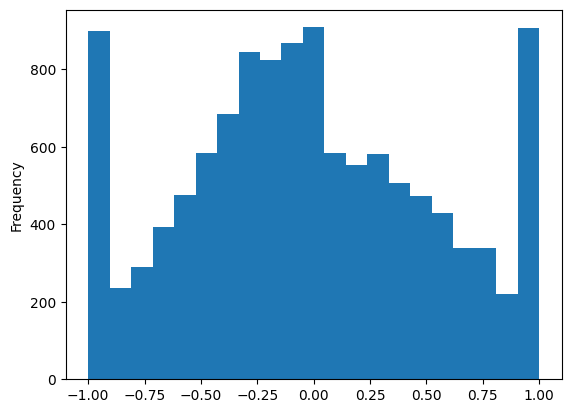

In [150]:
X_train['steering_angle'].plot.hist(bins=num_bins)

<Axes: ylabel='Frequency'>

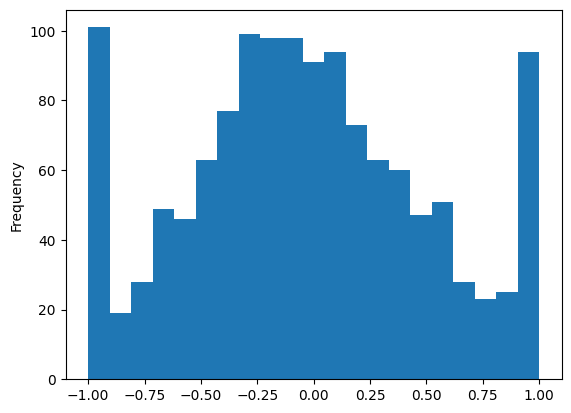

In [151]:
X_test['steering_angle'].plot.hist(bins=num_bins)

In [152]:
X_train.head()

,center,left,right,steering_angle,folder
14363,center_2019_04_02_18_10_19_211.jpg,left_2019_04_02_18_10_19_211.jpg,right_2019_04_02_18_10_19_211.jpg,-0.75,good 2
13133,center_2019_04_02_18_08_53_241.jpg,left_2019_04_02_18_08_53_241.jpg,right_2019_04_02_18_08_53_241.jpg,0.10,good 2
11100,center_2019_04_02_18_06_27_408.jpg,left_2019_04_02_18_06_27_408.jpg,right_2019_04_02_18_06_27_408.jpg,-0.40,good 2
28887,center_2019_04_02_18_27_28_821.jpg,left_2019_04_02_18_27_28_821.jpg,right_2019_04_02_18_27_28_821.jpg,-0.90,good 2
12145,center_2019_04_02_18_07_44_246.jpg,left_2019_04_02_18_07_44_246.jpg,right_2019_04_02_18_07_44_246.jpg,-1.00,good 2


In [153]:
X_train.to_csv('.\\data\\driving_train_log.csv', index=False)
X_test.to_csv('.\\data\\driving_test_log.csv', index=False)

# Load and Iterate Dataset

In [164]:
from data_module import read_driving_csv
X_train = read_driving_csv('.\\data\\driving_train_log.csv')

In [165]:
X_train.head()

,center,left,right,steering_angle,folder
0,center_2019_04_02_18_10_19_211.jpg,left_2019_04_02_18_10_19_211.jpg,right_2019_04_02_18_10_19_211.jpg,-0.75,good 2
1,center_2019_04_02_18_08_53_241.jpg,left_2019_04_02_18_08_53_241.jpg,right_2019_04_02_18_08_53_241.jpg,0.10,good 2
2,center_2019_04_02_18_06_27_408.jpg,left_2019_04_02_18_06_27_408.jpg,right_2019_04_02_18_06_27_408.jpg,-0.40,good 2
3,center_2019_04_02_18_27_28_821.jpg,left_2019_04_02_18_27_28_821.jpg,right_2019_04_02_18_27_28_821.jpg,-0.90,good 2
4,center_2019_04_02_18_07_44_246.jpg,left_2019_04_02_18_07_44_246.jpg,right_2019_04_02_18_07_44_246.jpg,-1.00,good 2
